In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
import pandas as pd
import numpy as np
from datetime import datetime
import time

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction='in')
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction='in') 

        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction='in')
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
df = pd.read_csv('df_TFR.csv', delimiter=',')
df["PGC1"] = df.pgc1
df["PGC1"] = df.apply(lambda x: x.PGC1 if x.PGC1 != 0 else x.PGC, axis=1)
df = df.set_index('PGC')

print(len(df))

catalogs = ["cf4", "spitzer", "cf2", "sfi", "2mtf", "flat"]
ind = (df["Vcmb_cf4"].isna()) | (df["Vcmb_cf4"]==0)
print(len(df["Vcmb_cf4"][ind]))

for cat in catalogs:
    ind = (df["Vcmb_cf4"].isna()) | (df["Vcmb_cf4"]==0)
    df["Vcmb_cf4"][ind] = df["Vcmb_"+cat][ind]
    
ind = (df["Vcmb_cf4"].isna()) | (df["Vcmb_cf4"]==0)
df["Vcmb_cf4"][ind] = np.nan

df = df.rename(columns={'Vcmb_cf4': 'Vcmb',
                       })

df.head()

12412
2950


,PGC1_cf4,Nest_cf4,DM_cf4,eDM_cf4,Vcmb,PGC1_spitzer,Nest_spitzer,DM_spitzer,eDM_spitzer,Vcmb_spitzer,...,w_2mtf,xw_2mtf,vw_2mtf,w_flat,xw_flat,vw_flat,logH_av,Vmod_av,pgc1,PGC1
PGC,,,,,,,,,,,,,,,,,,,,,
2,73150.0,200275.0,34.51,0.46,4726.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.777892,4785.113640,73150.0,73150.0
4,120.0,202766.0,33.49,0.49,4109.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.924339,4153.715722,120.0,120.0
12,12.0,210177.0,34.97,0.41,6195.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.805093,6296.413824,12.0,12.0
16,16.0,211419.0,34.63,0.45,5312.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.805318,5386.635077,16.0,16.0
55,55.0,0.0,33.83,0.60,4454.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.810702,4506.520342,55.0,55.0


In [4]:
len(df)

12412

In [5]:
import matplotlib.ticker

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_orderOfMagnitude(self, nothing):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin, vmax):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)

In [6]:
len(df[['DM_cf4']].dropna())




9304

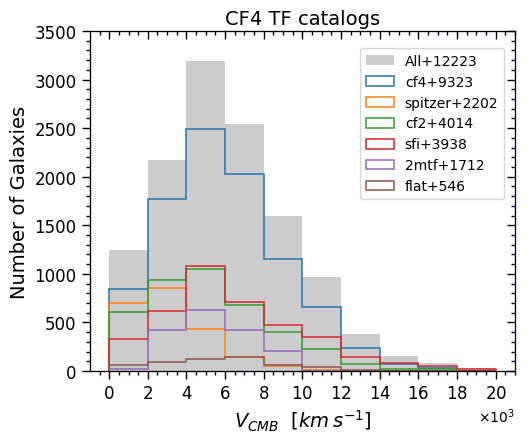

In [9]:
fig = plt.figure(figsize=(5, 4), dpi=100)
ax = fig.add_axes([0.13, 0.1, 0.85,  0.85])

bins=np.arange(0,22000,2000)

val = df.Vcmb.values
ax.hist(val, bins=bins, histtype='bar', label='All+12223', color='k', lw=1.7, alpha=0.2) 
# ax.hist(val, bins=bins, histtype='bar', label='All+'+str(len(val)), color='k', lw=1.7, alpha=0.2) 

val = df[df["DM_cf4"]>=0]["Vcmb"].values
ax.hist(val, bins=bins, histtype='step', label='cf4+9323', lw=1.1) 
# ax.hist(val, bins=bins, histtype='step', label='cf4+'+str(len(val)), lw=1.1) 

val = df[df["DM_spitzer"]>=0]["Vcmb"].values
ax.hist(val, bins=bins, histtype='step', label='spitzer+2202', lw=1.1)
# ax.hist(val, bins=bins, histtype='step', label='spitzer+'+str(len(val)), lw=1.1)

val = df[df["DM_cf2"]>=0]["Vcmb"].values
ax.hist(val, bins=bins, histtype='step', label='cf2+4014', lw=1.1) 
# ax.hist(val, bins=bins, histtype='step', label='cf2+'+str(len(val)), lw=1.1) 

val = df[df["DM_sfi"]>=0]["Vcmb"].values
ax.hist(val, bins=bins, histtype='step', label='sfi+3938', lw=1.1) 
# ax.hist(val, bins=bins, histtype='step', label='sfi+'+str(len(val)), lw=1.1) 

val = df[df["DM_2mtf"]>=0]["Vcmb"].values
ax.hist(val, bins=bins, histtype='step', label='2mtf+1712', lw=1.1) 
# ax.hist(val, bins=bins, histtype='step', label='2mtf+'+str(len(val)), lw=1.1) 

val = df[df["DM_flat"]>=0]["Vcmb"].values
ax.hist(val, bins=bins, histtype='step', label='flat+546', lw=1.1) 
# ax.hist(val, bins=bins, histtype='step', label='flat+'+str(len(val)), lw=1.1) 


# ax.set_yscale('log')
x_ax, y_ax = set_axes(ax, [-1000,21000], [0,3500], fontsize=12, inout='out')


ax.set_xlabel(r"$V_{CMB}$"+"  "+r'$[km \/ s^{-1}]$', fontsize=14)
ax.set_ylabel("Number of Galaxies", fontsize=14)

ax.legend(bbox_to_anchor=(0.62, 0.97), loc='upper left', fontsize=10)

x_ax.set_xticks(np.arange(0, 22000, step=2000))
ax.set_xticks(np.arange(0, 22000, step=2000))


ax.set_title("CF4 TF catalogs", fontsize=14, pad=5)

ax.xaxis.set_major_formatter(OOMFormatter(3, "%d"))
ax.ticklabel_format(axis='x', style='sci')

In [8]:
df.columns

Index([u'PGC1_cf4', u'Nest_cf4', u'DM_cf4', u'eDM_cf4', u'Vcmb',
       u'PGC1_spitzer', u'Nest_spitzer', u'DM_spitzer', u'eDM_spitzer',
       u'Vcmb_spitzer', u'PGC1_cf2', u'Nest_cf2', u'DM_cf2', u'eDM_cf2',
       u'Vcmb_cf2', u'PGC1_sfi', u'Nest_sfi', u'DM_sfi', u'eDM_sfi',
       u'Vcmb_sfi', u'PGC1_2mtf', u'Nest_2mtf', u'DM_2mtf', u'eDM_2mtf',
       u'Vcmb_2mtf', u'PGC1_flat', u'Nest_flat', u'DM_flat', u'eDM_flat',
       u'Vcmb_flat', u'Vmod_cf4', u'logH_cf4', u'Vmod_spitzer',
       u'logH_spitzer', u'Vmod_cf2', u'logH_cf2', u'Vmod_sfi', u'logH_sfi',
       u'Vmod_2mtf', u'logH_2mtf', u'Vmod_flat', u'logH_flat', u'w_cf4',
       u'xw_cf4', u'vw_cf4', u'w_spitzer', u'xw_spitzer', u'vw_spitzer',
       u'w_cf2', u'xw_cf2', u'vw_cf2', u'w_sfi', u'xw_sfi', u'vw_sfi',
       u'w_2mtf', u'xw_2mtf', u'vw_2mtf', u'w_flat', u'xw_flat', u'vw_flat',
       u'logH_av', u'Vmod_av', u'pgc1', u'PGC1'],
      dtype='object')

In [9]:
leda = pd.read_csv('Leda_bar.csv', delimiter='|')
leda = leda.set_index('PGC')

print(len(leda))

leda.head()

/home/ehsan/anaconda3/envs/py2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


397843


,objname,objtype,al1950,de1950,al2000,de2000,l2,b2,sgl,sgb,...,mod0,mabs,type,bar,ring,multiple,compactness,angclass,RA2000,DEC2000
PGC,,,,,,,,,,,,,,,,,,,,,
1,PGC000001,G,23.95695,0.42327,23.99966,0.70168,96.87946,-59.54180,293.35019,13.43002,...,0.00,0.00,24664.0,24588.0,24463.0,24126.0,37.82,0.0,-21.94,NaN
2,UGC12889,G,23.95786,46.99616,0.00047,47.27450,113.95535,-14.69916,341.64403,20.73880,...,15.27,1.96,5319.0,5217.0,5212.0,4751.0,34.40,0.0,-21.10,NaN
4,PGC000004,G,23.95829,22.80927,0.00096,23.08764,107.83219,-38.27289,316.05865,18.45140,...,16.51,1.12,4724.0,4628.0,4555.0,4123.0,34.11,0.0,-18.72,NaN
5,IC5370,G,23.95988,32.46003,0.00254,32.73839,110.62060,-28.90431,326.17705,19.78055,...,0.00,0.00,10730.0,10629.0,10582.0,10129.0,35.95,0.0,-21.43,NaN
6,PGC000006,G,23.95790,15.60327,0.00058,15.88165,105.25252,-45.21822,308.62424,17.10314,...,17.71,2.47,6246.0,6155.0,6063.0,5655.0,34.72,0.0,-19.49,NaN


In [10]:
how = 'inner'

df = df.join(leda, lsuffix='_cf4', rsuffix='_leda', how=how)
df = df[["PGC1", "Vcmb", "sgl", "sgb"]]

# df.sort_values(by=['PGC1'])

print(len(df))

df.head()

12409


,PGC1,Vcmb,sgl,sgb
PGC,,,,
2,73150.0,4726.0,341.64403,20.73880
4,120.0,4109.0,316.05865,18.45140
12,12.0,6195.0,286.42487,11.35107
16,16.0,5312.0,287.61198,11.70296
55,55.0,4454.0,327.09965,19.77625


In [11]:
dg = df.groupby('PGC1').agg(["mean", "count"])

dg.head()

Vcmb              sgl             sgb      
         mean count       mean count      mean count
PGC1                                                
12.0   6195.0     1  286.42487     1  11.35107     1
14.0  10883.0     1  300.97120     1  16.09477     1
16.0   5312.0     1  287.61198     1  11.70296     1
55.0   4454.0     1  327.09965     1  19.77625     1
63.0   8166.0     1  321.61600     1  19.67373     1

In [12]:
dg.loc[12].Vcmb['count']


1.0

In [13]:
df["Vgrp"] = df["PGC1"].apply(lambda x: dg.loc[x].Vcmb['mean'])
df["Ngrp"] = df["PGC1"].apply(lambda x: dg.loc[x].Vcmb['count'])

df.head()

,PGC1,Vcmb,sgl,sgb,Vgrp,Ngrp
PGC,,,,,,
2,73150.0,4726.0,341.64403,20.73880,4735.5,2.0
4,120.0,4109.0,316.05865,18.45140,4272.0,3.0
12,12.0,6195.0,286.42487,11.35107,6195.0,1.0
16,16.0,5312.0,287.61198,11.70296,5312.0,1.0
55,55.0,4454.0,327.09965,19.77625,4454.0,1.0


In [14]:
df = df.sort_values(by=['Vgrp', 'PGC1'])

df.head(20)

,PGC1,Vcmb,sgl,sgb,Vgrp,Ngrp
PGC,,,,,,
3974,3974.0,-167.0,313.33597,1.60643,-167.000000,1.0
15345,13826.0,-151.0,11.91144,-4.91736,-151.000000,1.0
1014,1014.0,-117.0,256.24917,-2.35943,-117.000000,1.0
2758,2789.0,-137.0,275.92255,-3.72988,-90.000000,2.0
2789,2789.0,-43.0,271.56523,-5.00912,-90.000000,2.0
3238,3238.0,-89.0,259.81022,-9.50307,-89.000000,1.0
7671,7671.0,-64.0,328.80608,-6.30704,-64.000000,1.0
67908,67908.0,-63.0,234.23183,11.52843,-63.000000,1.0
73049,73049.0,-53.0,261.30113,3.12136,-53.000000,1.0


In [15]:
import sys
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import  lines
from matplotlib import rc, rcParams
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.patches import Polygon, Ellipse
import numpy as np
from math import *
from time import time
import wl_to_rgb as col
import random
from astropy.io import ascii
from astropy.table import Table, Column 
import pyfits
import pylab as py
from astropy import coordinates as coord
from astropy import units as unit
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.patches as mpatches

from matplotlib import *

/home/ehsan/anaconda3/envs/py2/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [16]:

vel = df.Vcmb.values
vel = df.Vgrp.values

# vel = (vel-np.min(vel)) / (np.max(vel)-np.min(vel)) + 1
# vel = np.log10(vel)
# Mvel = np.median(vel)
# vel = vel / Mvel / 2.

print np.min(vel), np.max(vel)

-167.0 28349.0


CPU times: user 21min 22s, sys: 4.3 s, total: 21min 26s
Wall time: 21min 24s


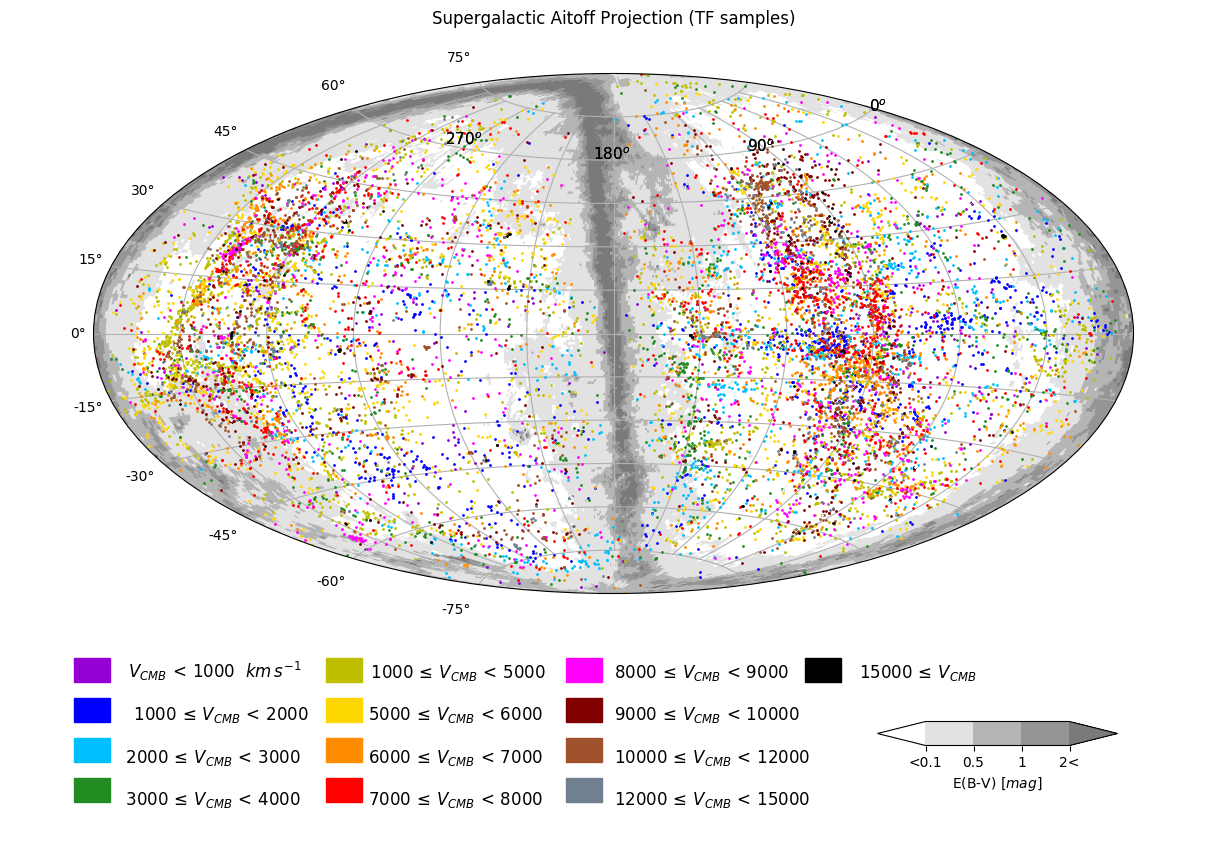

In [17]:
%%time 

l0 = 180

deg = 0.8
a = pyfits.open('EBV.0.8.deg.fits')
d = a[1].data


SGL  = d['SGL']
SGB  = d['SGB']
EBV = d['EBV']

fig = plt.figure(figsize=(12, 8), dpi=100)
ax = fig.add_subplot(111, projection="aitoff")
plt.title("Supergalactic Aitoff Projection (TF samples)", y=1.08)
ax.grid(True)
ax.set_xticklabels([])
plt.subplots_adjust(top=0.95, bottom=0.3, right=0.95, left=0.05)

ax.annotate(r'$0^o$', (pi-0.1,pi/3.), size=11, color='black')
ax.annotate(r'$90^o$', (pi/2.-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$180^o$', (-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$270^o$', (-pi/2.-0.2,pi/3.), size=11, color='black')


ax.annotate(r'$0^o$', (pi-0.1,pi/3.), size=11, color='black')
ax.annotate(r'$90^o$', (pi/2.-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$180^o$', (-0.2,pi/3.), size=11, color='black')
ax.annotate(r'$270^o$', (-pi/2.-0.2,pi/3.), size=11, color='black')  
################################################################ 
################################################################ 
def xymap_aitoff(x, y):
  
    while x > 360:
        x-=360
    while x < 0:
        x+=360

    x0 = (180.-x)*pi/180.
    y0 = y*pi/180.
  
    return x0, y0
################################################################ 

def esn_aitoff_patch(ax, x0, y0, d, color='blue'):

    vertices = []
    x, y = xymap_aitoff(x0,y0) 
    vertices.append([x,y])
    x, y = xymap_aitoff(x0,y0+d) 
    vertices.append([x,y])
    x, y = xymap_aitoff(x0+d,y0+d) 
    vertices.append([x,y])
    x, y = xymap_aitoff(x0+d,y0) 
    vertices.append([x,y]) 
    ax.add_patch(Polygon(vertices, closed=True, fill=True, color=color))


jet = cm = plt.get_cmap('Greys')
cNorm  = colors.Normalize(vmin=0, vmax=5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

for i in range(len(SGB)):
    if EBV[i]>2.0: val = 3
    elif EBV[i]>1.0: val = 2.5
    elif EBV[i]>0.5: val= 2.0
    elif EBV[i]<=0.5 and EBV[i]>0.1: val= 1.0
    elif EBV[i]<0.1: val= 0
    else: val= 0
    colorVal = scalarMap.to_rgba(val)
    esn_aitoff_patch(ax, SGL[i], SGB[i], deg, color=colorVal)

    
    
# N = len(SGL)
# X = np.zeros(N)
# Y = np.zeros(N)
# for i in range(N):
#     X[i], Y[i] = xymap_aitoff(SGL[i], SGB[i])    
# ax.scatter(X, Y, marker='.', color='black')


sgl_gal = df.sgl.values
sgb_gal = df.sgb.values
N = len(sgl_gal)
X = np.zeros(N)
Y = np.zeros(N)
for i in range(N):
    X[i], Y[i] = xymap_aitoff(sgl_gal[i], sgb_gal[i])
    
############################################
    
# vel_col = np.zeros(N)   
# Velocity = df.Vcmb.values
# for i, v in enumerate(vel):
#     vel_col[i] = 0
#     if v<=0:
#         vel_col[i] = 0.1
#     elif v>=11000:
#         vel_col[i] = 1
#     else:
#         vel_col[i] = 0.1+0.9*v/11000.
    
# colours = pl.cm.nipy_spectral(vel_col)

############################################
col_pallet = ['darkviolet', 'blue', 'deepskyblue', 'forestgreen', 'y', 'gold', 'darkorange', 'red', 'magenta', 'maroon', 'sienna', 'slategrey', 'black']
vel_pallet = [-100000, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 12000, 15000, 20000]
def color_table(Velocity):
    colours = []
    for j, v in enumerate(Velocity):
        col = "white"
        for i in range(len(vel_pallet)-1):
            if vel_pallet[i] <= v and v < vel_pallet[i+1]:
                col = col_pallet[i]
                break
        colours.append(col)
    return colours

colours = color_table(df.Vgrp.values)
############################################

ax2 = plt.axes([0,0,1,1], facecolor=(1,1,1,0))
ax2.set_axis_off()
ax2.set_xticks([])
ax2.set_yticks([])
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.annotate(r"$\/\/ V_{CMB} \/ < \/ 1000 \/\/\/\/ km\/ s^{-1}  $", (0.1,0.2), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$ \/\/\/\/ 1000 \/ \leq \/ V_{CMB} \/ < \/ 2000$', (0.1,0.2-0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$\/ 2000 \/ \leq \/ V_{CMB} \/ < \/ 3000$', (0.1,0.2-2*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$\/ 3000 \/ \leq \/ V_{CMB} \/ < \/ 4000$', (0.1,0.2-3*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$\/ 1000 \/ \leq \/ V_{CMB} \/ < \/ 5000$', (0.30,0.2), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$5000 \/ \leq \/ V_{CMB} \/ < \/ 6000$', (0.30,0.2-0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$6000 \/ \leq \/ V_{CMB} \/ < \/ 7000$', (0.30,0.2-2*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$7000 \/ \leq \/ V_{CMB} \/ < \/ 8000$', (0.30,0.2-3*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$8000 \/ \leq \/ V_{CMB} \/ < \/ 9000$', (0.5,0.2), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$9000 \/ \leq \/ V_{CMB} \/ < \/ 10000$', (0.5,0.2-0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$10000 \/ \leq \/ V_{CMB} \/ < \/ 12000$', (0.5,0.2-2*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$12000 \/ \leq \/ V_{CMB} \/ < \/ 15000$', (0.5,0.2-3*0.05), xycoords='figure fraction', size=12, color='black')
ax2.annotate(r'$15000 \/ \leq \/ V_{CMB}$', (0.7,0.2), xycoords='figure fraction', size=12, color='black')

p = 0
for m in [0.1,0.31,0.51]:
    for n in [0.19,0.19-0.05,0.19-2*0.05,0.19-3*0.05]:
        ax2.add_patch(patches.Rectangle((m-0.05, n), 0.03, 0.03, color=col_pallet[p]))
        p+=1
ax2.add_patch(patches.Rectangle((0.71-0.05, 0.19), 0.03, 0.03, color=col_pallet[p]))
############################################
################################################################ 
jet = cm = plt.get_cmap('Greys')
cNorm  = colors.Normalize(vmin=0, vmax=5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
ax3 = fig.add_axes([0.720, 0.11, 0.2, 0.03])
cols = []
bounds = [0,1,2,3]
#cols.append(scalarMap.to_rgba(0))
cols.append(scalarMap.to_rgba(1.0))
cols.append(scalarMap.to_rgba(2.0))
cols.append(scalarMap.to_rgba(2.5))
#cols.append(scalarMap.to_rgba(3.0))



cm = colors.ListedColormap(cols)

cm.set_over(scalarMap.to_rgba(3.0))
cm.set_under(scalarMap.to_rgba(0))

cNorm  = colors.BoundaryNorm(bounds, cm.N)
cbar = colorbar.ColorbarBase(ax3, cmap=cm, norm=cNorm, orientation='horizontal',ticks=bounds, boundaries=[-1]+bounds+[4],extend='both',extendfrac='auto')
cbar.set_ticks(bounds)
cbar.ax.tick_params(labelsize=10) 
cbar.ax.set_xticklabels(['<0.1','0.5','1','2<'])  # horizontal colorbar

cbar.set_label('E(B-V) '+r'$[mag]$')
################################################################   



# ax.scatter(X, Y, color=colours, marker='.', s=3)

for i, c in enumerate(colours):
    ax.plot([X[i]], [Y[i]], color=c, marker='.', ms=2)